In [1]:
# !pip install category-encoders

In [2]:
import re
import numpy as np
import pandas as pd
import xgboost as xgb
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

### Python Libraries and Modules for Machine Learning

#### Basic Libraries
- **`re`**: Provides regular expression matching operations similar to those found in Perl. Useful for string manipulation and text data processing.

#### Data Handling and Computation
- **`numpy`** (imported as `np`): A fundamental package for scientific computing with Python. It offers powerful N-dimensional array objects, and tools for integrating C/C++ and Fortran code.
- **`pandas`** (imported as `pd`): Provides high-performance, easy-to-use data structures and data analysis tools. Ideal for handling structured data.

#### Machine Learning Models and Tools
- **`xgboost`** (imported as `xgb`): Implements gradient boosting framework. Used for building fast and high performance gradient boosting tree models.
- **`category_encoders`** (imported as `ce`): A library featuring several encoders for converting categorical data into numerical format, suitable for machine learning models.
- **`sklearn.ensemble.RandomForestClassifier`**: Part of scikit-learn, this is used for creating a Random Forest classifier that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

#### Model Evaluation and Selection
- **`sklearn.model_selection.train_test_split`**: Splits arrays or matrices into random train and test subsets.
- **`sklearn.model_selection.GridSearchCV`**: Exhaustive search over specified parameter values for an estimator, useful for cross-validating the best model parameters.

#### Performance Metrics
- **`sklearn.metrics.confusion_matrix`**: Computes the confusion matrix to evaluate the accuracy of a classification.
- **`sklearn.metrics.ConfusionMatrixDisplay`**: Visualization for the confusion matrix.
- **`sklearn.metrics.accuracy_score`**: Used to calculate the accuracy of either the fraction (default) or the count (normalize=False) of correct predictions.

#### Visualization
- **`matplotlib.pyplot`** (imported as `plt`): Provides a MATLAB-like plotting framework. Useful for making plots and graphs for data visualization.


In [3]:
# train_data = pd.read_csv('train.csv')
# test_data = pd.read_csv('test.csv')
# sub_data = pd.read_csv('gender_submission.csv')
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
sub_data = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Working with Titanic Dataset in Kaggle

The code snippet below is used to load the Titanic dataset from Kaggle's file structure, which includes three CSV files: one for training, one for testing, and one for submission examples. This dataset is commonly used in introductory data science competitions to predict which passengers survived the Titanic shipwreck.

#### Code Explanation
- **Train Data**:
  ```python
  train_data = pd.read_csv('/kaggle/input/titanic/train.csv')


In [4]:
all_data = [train_data, test_data]
for dataset in all_data:
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].mean())
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].mean())
    dataset['Has_Cabin'] = dataset['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
    dataset.drop(['Cabin'], axis=1, inplace=True)

### Data Preprocessing for Titanic Dataset

The following code snippet demonstrates the preprocessing steps applied to both the training and testing datasets from the Titanic dataset. These steps are crucial for preparing the data for a machine learning model.

#### Overview
We combine the training and testing datasets into a list to apply the same transformations across both datasets efficiently.

#### Code Explanation
- **Combining Data**:
  ```python
  all_data = [train_data, test_data]


In [5]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

### Extracting Titles from Names

#### Function: `get_title`

The `get_title` function is designed to extract the title (such as Mr, Mrs, Miss, etc.) from a person's full name. This is particularly useful in datasets where names include titles that may indicate social status, gender, or marital status, which can be relevant features for analysis or machine learning models.

#### Code Explanation
```python
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""


In [6]:
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(
        ['Countess', 'Lady', 'Sir', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

### Feature Engineering on Titanic Dataset

The following code segments are used to create and manipulate new features in both the training and testing datasets from the Titanic dataset. These transformations help to enrich the data with new insights that might improve the performance of a machine learning model.

#### Creating New Features

1. **Extract Titles from Names**:
   ```python
   for dataset in all_data:
       dataset['Title'] = dataset['Name'].apply(get_title)


In [7]:
for dataset in all_data:
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0, 12, 18, 24, 35, 60, 120],
                                labels=['Children', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elder'])
    
    dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0, 7.91, 14.45, 31, 120],
                                 labels=['low_fare', 'median_fare', 'average_fare', 'high_fare'])

### Further Feature Engineering on Titanic Dataset

#### Categorizing Age and Fare

The code snippet below categorizes two continuous features, `Age` and `Fare`, into predefined bins. This transformation can help in identifying patterns that are more evident in categorical data and might improve the predictive accuracy of machine learning models.

1. **Categorizing Age**:
   ```python
   for dataset in all_data:
       dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0, 12, 18, 24, 35, 60, 120],
                                   labels=['Children', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elder'])


In [8]:
for col in ['Pclass', 'Title', 'Sex', 'Age', 'SibSp', 'Parch', 'FamilySize', 'Fare', 'Embarked', 'Has_Cabin']:
    print(train_data[col].value_counts())

Pclass
3    491
1    216
2    184
Name: count, dtype: int64
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64
Sex
male      577
female    314
Name: count, dtype: int64
Age
29.699118    177
24.000000     30
22.000000     27
18.000000     26
28.000000     25
            ... 
36.500000      1
55.500000      1
0.920000       1
23.500000      1
74.000000      1
Name: count, Length: 89, dtype: int64
SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64
Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64
FamilySize
1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: count, dtype: int64
Fare
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: count, Length: 248, dtype: int64
Embarked
S    646
C    168
Q     77


In [9]:
train_df = train_data
test_df = test_data
all_df = [train_df, test_df]

In [10]:
for dataset in all_df:
    drop_column = ['Age', 'Name', 'Ticket', 'SibSp', 'Fare']
    dataset.drop(drop_column, axis=1, inplace=True)

train_df.drop('PassengerId', axis=1, inplace=True)

In [11]:
x = train_df.drop('Survived', axis=1)
y = train_df['Survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
x_train

,Pclass,Sex,Parch,Embarked,Has_Cabin,Title,FamilySize,Age_bin,Fare_bin
570,2,male,0,S,0,Mr,1,Elder,median_fare
787,3,male,1,Q,0,Master,6,Children,average_fare
74,3,male,0,S,0,Mr,1,Young Adult,high_fare
113,3,female,0,S,0,Miss,2,Student,median_fare
635,2,female,0,S,0,Miss,1,Young Adult,median_fare
...,...,...,...,...,...,...,...,...,...
106,3,female,0,S,0,Miss,1,Student,low_fare
270,1,male,0,S,0,Mr,1,Young Adult,average_fare
860,3,male,0,S,0,Mr,3,Adult,median_fare
435,1,female,2,S,1,Miss,4,Teenager,high_fare


### Splitting the Titanic Dataset into Train and Test Sets

#### Purpose
Splitting the data into training and test sets is a fundamental step in preparing data for building and validating machine learning models. This approach helps in evaluating the performance of a model on unseen data, ensuring that the model generalizes well beyond the data on which it was trained.

#### Code Explanation

1. **Preparing the Features and Target**:
   ```python
   x = train_df.drop('Survived', axis=1)
   y = train_df['Survived']


In [12]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((534, 9), (357, 9), (534,), (357,))

In [13]:
encoder = ce.OrdinalEncoder()
x_train = encoder.fit_transform(x_train)
x_test = encoder.fit_transform(x_test)
test_df = encoder.fit_transform(test_data)
x_train

,Pclass,Sex,Parch,Embarked,Has_Cabin,Title,FamilySize,Age_bin,Fare_bin
570,2,1,0,1,0,1,1,6,2
787,3,1,1,2,0,2,6,1,3
74,3,1,0,1,0,1,1,4,4
113,3,2,0,1,0,3,2,3,2
635,2,2,0,1,0,3,1,4,2
...,...,...,...,...,...,...,...,...,...
106,3,2,0,1,0,3,1,3,1
270,1,1,0,1,0,1,1,4,3
860,3,1,0,1,0,1,3,5,2
435,1,2,2,1,1,3,4,2,4


Accuracy = 0.7759103641456583


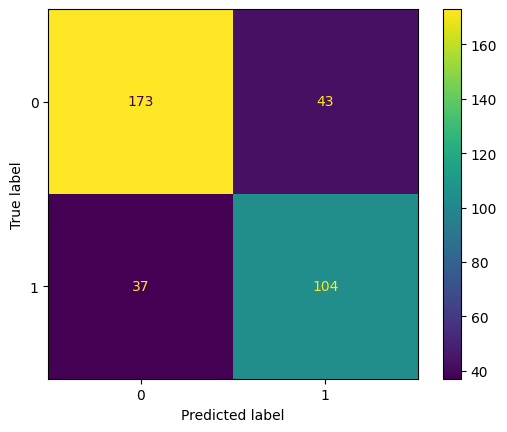

In [14]:
model = xgb.XGBClassifier(n_estimators=15, max_depth=3, subsample=0.5, gamma=1, eta=0.1,
                      min_child_weight=4, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(f'Accuracy = {accuracy_score(y_pred, y_test)}')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

### Training and Evaluating an XGBoost Classifier on the Titanic Dataset

#### Purpose
The aim is to build a predictive model using the XGBoost classifier to determine the survival outcomes of passengers in the Titanic dataset. The model is then evaluated based on its accuracy and a confusion matrix to visualize its performance.

#### Model Setup
1. **XGBoost Classifier Configuration**:
   ```python
   model = xgb.XGBClassifier(n_estimators=15, max_depth=3, subsample=0.5, gamma=1, eta=0.1,
                             min_child_weight=4, random_state=42, n_jobs=-1)


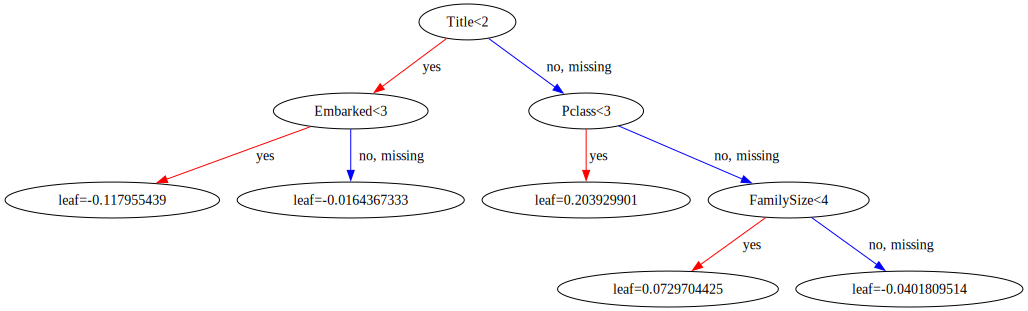

In [15]:
xgb.to_graphviz(model)

In [16]:
# model = XGBClassifier(subsample=0.5)
# params = {
#     'n_estimators': [15, 30, 50, 100],
#     'max_depth': [3, 6, 10, 20],
#     'eta': [0.01, 0.1, 0.2, 0.3],
#     'gamma': [0.4, 0.5, 0.6, 0.7, 1],
#     'min_child_weight': [2, 3, 4, 5, 7, 9],
# }
# grid_search_CV = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring="accuracy")
# grid_search_CV.fit(x_train, y_train)

In [17]:
# best_model = grid_search_CV.best_estimator_
# best_model

In [18]:
# grid_search_CV.best_params_

In [19]:
# best_model.score(x_test, y_test)

Accuracy = 0.916267942583732


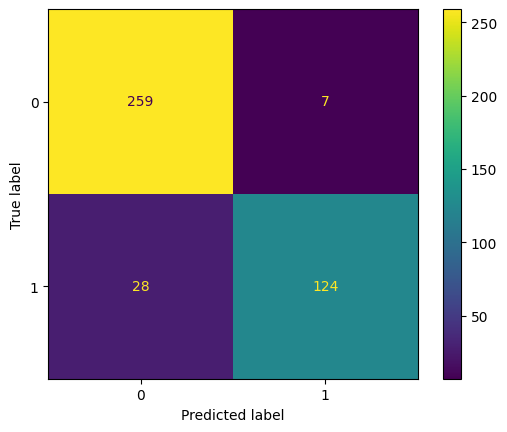

In [20]:
sub_pred = model.predict(test_df.drop('PassengerId', axis=1))
sub_test = sub_data['Survived']
print(f'Accuracy = {accuracy_score(sub_pred, sub_test)}')
cm = confusion_matrix(sub_test, sub_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

### Making Predictions and Evaluating the XGBoost Model on Submission Test Data

#### Purpose
The purpose of this segment is to apply the trained XGBoost classifier to an external test dataset and evaluate its accuracy using a known set of outcomes. This helps to validate the model's effectiveness in a scenario that mimics real-world application, such as submitting predictions in a competition.

#### Model Prediction
1. **Generating Predictions**:
   ```python
   sub_pred = model.predict(test_df.drop('PassengerId', axis=1))


In [21]:
df = pd.DataFrame({'PassengerId': sub_data['PassengerId'], 'Survived': sub_pred})
df.to_csv('/kaggle/working/submission.csv', index=False)